In [25]:
import ast
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit


def get_path(fname):
    return os.path.join(
        '/Users/felipe/git-repos/computacional/practica/trabajo_1/valores',
        fname)


DIMS = [4, 16, 32, 64, 128]

Valores para Ejercicio a)

In [ ]:
df = pd.read_csv(get_path('valores_a.dat'))
probabilidades_criticas = df.groupby('L').agg(['mean', 'std'])

probabilidades_criticas

### F(p)

In [ ]:
# F(P)

for dim in DIMS:
    df = pd.read_csv(f'../valores/{dim}.dat')
    plt.plot(df.p, df['F(p)'], label=f'L = {dim}')
plt.grid()
plt.xlabel('Probabilidad de llenado de red')
plt.ylabel('Probabilidad de percolacion')
plt.legend()
plt.show()

### f(p)

In [ ]:
for dim in DIMS:
    df = pd.read_csv(get_path(f'{dim}.dat'))
    plt.plot(df.p, np.gradient(df['F(p)'], df.p), label=f'L = {dim}')
plt.grid()
plt.xlabel('Probabilidad de llenado de red')
plt.legend()
plt.show()

### Probabilidad critica en funcion del ancho

In [ ]:
p_c_mediana = []
p_c_media = []
anchos = []

for dim in DIMS:
    df = pd.read_csv(get_path(f'{dim}.dat'))
    f = np.gradient(df['F(p)'], df.p)
    mu, std = norm.fit(f)

    p_c_mediana.append(df[df['F(p)'] >= 0.5].p.min())
    p_c_media.append(np.trapz(f * df.p, df.p))
    anchos.append(np.sqrt(np.trapz(f * df.p * df.p, df.p) - np.trapz(f * df.p, df.p) ** 2))

print(p_c_media)
print(anchos)

In [ ]:
!pip3 install sklearn

In [ ]:
x = np.arange(0, 0.07, 0.01)
coeffs, cov = np.polyfit(anchos[1:], p_c_media[1:], 1, w=list(map(lambda x: 1 / x ** 1.3, anchos[1:])), cov=True)

print('({:.4f} \pm {:.4f})'.format(coeffs[-1], np.sqrt(cov[-1, -1])))

plt.plot(anchos[1:], p_c_media[1:], '*', label='Datos')
plt.plot(x, sum([x ** i * coeff for i, coeff in enumerate(np.flip(coeffs))]), 'r', label='Ajuste')
plt.xlabel('Dispercion')
plt.ylabel('Probabilidad critica')
plt.legend()
plt.grid()
# plt.show()
plt.savefig('../images/ajuste.png')

### ln(n_s) vs s

In [ ]:
from scipy.special import zeta

df = pd.read_csv(get_path('valores_d.dat'))
frags = df.query('L == 128').fragmentos.apply(lambda x: np.array(ast.literal_eval(x)) / 128 ** 2).iloc[0]

length = 200
y = np.log(frags[0:length])
x = np.log(np.arange(1, length + 1))
p_c = 0.592585


def tau(x, tau, b):
    return b - tau * x
    

coeffs, cov = curve_fit(tau, x, y, p0=(2.01, -4))
print(fr'\tau = ({coeffs[0]:.6f} \pm {cov[0, 0]:.6f})')

plt.plot(x, y, '*', label='Datos')
plt.plot(x, tau(x, *coeffs), '-', label='Ajuste')
plt.grid()
plt.legend()
plt.ylabel('$n_s$ (log)')
plt.xlabel('$s$ (log)')
plt.savefig('../images/n_s_vs_s_ajuste.png')
plt.close()



def tau(x, tau):
    return np.log(p_c / zeta(tau - 1)) - tau * x
    

coeffs, cov = curve_fit(tau, x, y, p0=(2.01, ))
print(fr'\tau = ({coeffs[0]:.6f} \pm {cov[0, 0]:.6f})')

plt.plot(x, y, '*', label='Datos')
plt.plot(x, tau(x, *coeffs), '-', label='Ajuste')
plt.grid()
plt.legend()
plt.ylabel('$n_s$ (log)')
plt.xlabel('$s$ (log)')
plt.savefig('../images/n_s_vs_s_ajuste_mejor.png')

### Dimension fractal

In [ ]:
df = pd.read_csv(get_path('valores_3.dat'))

In [ ]:
x = np.log(df.L.values)
y = np.log(df.masa.values)

coeffs, cov = np.polyfit(x, y, 1, cov=True)

print(f'm = ({coeffs[0]:.4f} \pm {cov[0, 0]:.4f})')

plt.plot(x, y, '*')
plt.plot(np.arange(x[0], x[-1], (x[-1] - x[0]) / 100), np.arange(x[0], x[-1], (x[-1] - x[0]) / 100) * coeffs[0] + coeffs[1], '-')
plt.grid()
plt.xlabel('L (log)')
plt.ylabel('Masa (log)')
plt.savefig('../images/masa_vs_l.png')

### P_\infty

In [ ]:
df = pd.read_csv(get_path('valores_2.dat'))
df.masa = df.apply(lambda x: x['masa'] / x['L'] ** 2, axis=1)
df = df.query('L == 128')

In [ ]:
x = df.p.values
y = df.masa.values

plt.plot(x, y, '*')
plt.grid()
plt.xlabel('p')
plt.ylabel('Masa')
plt.savefig('../images/masa_vs_p.png')

In [ ]:
from scipy.optimize import curve_fit


def beta(x, A, beta):
    return A * x ** beta


df = pd.read_csv(get_path('valores_2_fino.dat'))
df.masa = df.apply(lambda x: x['masa'] / x['L'] ** 2, axis=1)
df = df.query('L == 128')

x = df.p.values
y = df.masa.values

p_c = 0.592585
p_c = 0.594

y = y[x > p_c]
x = x[x > p_c]

x = x - p_c

popt, pcov = curve_fit(beta, x, y, p0=(1, 0.138))

print(popt)

print(f'beta = ({popt[1]:.4f} \pm {pcov[1, 1]:.4f})')


plt.plot(x, y, '*', label='Datos')
plt.plot(x, beta(x, *popt), '-', label='Ajuste')
plt.grid()
plt.legend()
plt.xlabel('p')
plt.ylabel('Masa')
plt.savefig('../images/masa_vs_p_fit.png')

Tomo para L == 128, p_c(128) =0.592585.

### Ejercicio 4

In [26]:
import ast

df = pd.read_csv(get_path('valores_4_2.dat'))
df.n_s = df.n_s.apply(lambda x: np.array(ast.literal_eval(x)))

min_len = df.n_s.apply(len).min()
df.n_s = df.n_s.apply(lambda x: x[:min_len])

n_s_p_c = df.n_s[df.p.apply(lambda x: abs(x - 0.592639)).idxmin()]

In [27]:
df['f_z'] = df.n_s.apply(lambda x: x / n_s_p_c)

In [28]:
df.head()

,p,n_s,f_z
0,0.400,"[221.2705, 64.8822, 40.479, 26.8901, 19.2006, ...","[3.035568768297468, 4.150574778820504, 4.31191..."
1,0.401,"[220.2882, 64.581, 40.1907, 26.7525, 19.1517, ...","[3.0220927775933357, 4.1313067342199705, 4.281..."
2,0.402,"[219.4952, 64.3836, 40.05, 26.8202, 19.0339, 1...","[3.0112137583238905, 4.118678872320418, 4.2662..."
3,0.403,"[218.659, 64.0551, 39.8574, 26.7213, 18.9909, ...","[2.999742086302313, 4.097664421286967, 4.24570..."
4,0.404,"[217.6762, 63.8153, 39.6942, 26.5581, 18.8656,...","[2.986259236191328, 4.082324191887206, 4.22832..."


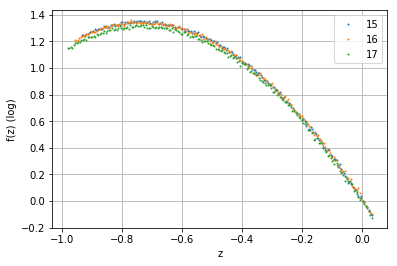

In [29]:
p_c = 0.5925

for i in range(15, 18):
    plt.plot(i ** 0.39 * (df.p - p_c) / p_c, np.log(df.f_z.apply(lambda x: x[i])), '.', markersize=2, label=f'{i}')
plt.xlabel('z')
plt.ylabel('f(z) (log)')
plt.grid()
plt.legend()
plt.savefig('../images/f_vs_z.png')

### 5


Busco f_max para conseguir p_max en funcion de s.

\sigma = (0.40 \pm 0.02)


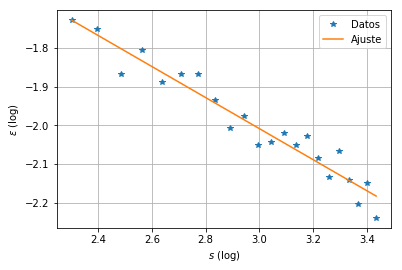

In [33]:
df.f_z = df.f_z.apply(np.array)

ss = np.arange(10, 32, 1)
p_max = []

for s in ss:
    index = df.f_z.apply(lambda x: x[s]).idxmax()
    p_max.append(df.loc[index].p)
    
p_max = np.array(p_max)

x = np.log(ss)
y = np.log(abs(p_max - p_c))

coeffs, cov = np.polyfit(x, y, 1, cov=True)

print(f'\sigma = ({-coeffs[0]:.2f} \pm {np.sqrt(cov[0,0]):.2f})')

plt.plot(x, y, '*', label='Datos')
plt.plot(x, coeffs[0] * x + coeffs[1], label='Ajuste')
plt.grid()
plt.xlabel('$s$ (log)')
plt.ylabel('$\epsilon$ (log)')
plt.legend()
plt.savefig('../images/eps_vs_s_ajuste.png')

### Ejercicio 6

In [34]:
df = pd.read_csv(get_path('valores_6.dat'))
df.n_s = df.n_s.apply(lambda x: np.array(ast.literal_eval(x)))

min_len = df.n_s.apply(len).min()
df.n_s = df.n_s.apply(lambda x: x[:min_len])

In [35]:
from functools import reduce

df['m2'] = df.n_s.apply(lambda x: sum(x / 128 ** 2 * np.arange(1, 2001) * np.arange(1, 2001)))

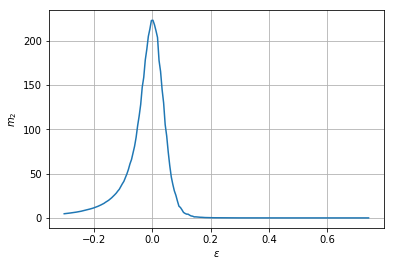

In [36]:
p_c = 0.572585

x = (df.p.values - p_c) / p_c
y = df.m2.values

plt.plot(x, y)
plt.xlabel('$\epsilon$')
plt.ylabel('$m_2$')
plt.grid()
plt.savefig('../images/m_2_vs_epsilon.png')

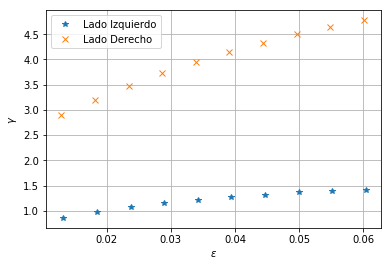

In [37]:
x = (df.p.values - p_c) / p_c
y = df.m2.values

# Lado Izquierdo

x_iz = np.flip(- x[x < - 0.01])
y_iz = np.flip(y[x < - 0.01])

y_iz = y_iz[x_iz < 0.1]
x_iz = x_iz[x_iz < 0.1]

e_iz = []
gamma_iz = []
for i in range (10):
    coeffs, cov = np.polyfit(np.log(x_iz[i:]), np.log(y_iz[i:]), 1, cov=True)
    
    e_iz.append(x_iz[i])
    gamma_iz.append(-coeffs[0])

e_iz = np.array(e_iz)
gamma_iz = np.array(gamma_iz)
    
# Lado derecho

x_d = x[x > 0.01]
y_d = y[x > 0.01]

y_d = y_d[x_d < 0.2]
x_d = x_d[x_d < 0.2]

e_d = []
gamma_d = []
for i in range (10):
    coeffs, cov = np.polyfit(np.log(x_d[i:]), np.log(y_d[i:]), 1, cov=True)
    
    e_d.append(x_d[i])
    gamma_d.append(-coeffs[0])
    
e_d = np.array(e_d)
gamma_d = np.array(gamma_d)

plt.plot(e_iz, gamma_iz, '*', label='Lado Izquierdo')
plt.plot(e_d, gamma_d, 'x', label='Lado Derecho')
plt.xlabel('$\epsilon$')
plt.ylabel('$\gamma$')
plt.legend()
plt.grid()
plt.savefig('../images/gamma_vs_epsilon.png')

\gamma = (2.12 \pm 0.11)


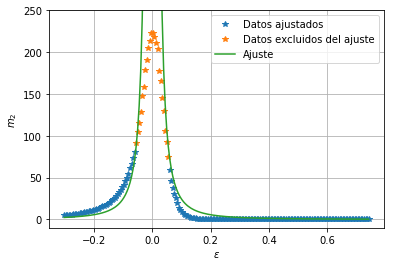

In [38]:
def gamma(x, gamma, A):
    return abs(x) ** (- gamma) * A


limite = 0.06
    

coeffs, cov = curve_fit(gamma, x[abs(x) > limite], y[abs(x) > limite], p0=(2.38, 10))
print(fr'\gamma = ({coeffs[0]:.2f} \pm {np.sqrt(cov[0, 0]):.2f})')

plt.plot(x[abs(x) > limite], y[abs(x) > limite], '*', label='Datos ajustados')
plt.plot(x[abs(x) <= limite], y[abs(x) <= limite], '*', label='Datos excluidos del ajuste')
plt.plot(x, gamma(x, *coeffs), '-', label='Ajuste')
plt.grid()
plt.legend()
plt.ylim([-10, 250])
plt.ylabel('$m_2$')
plt.xlabel('$\epsilon$')
plt.savefig('../images/m_2_vs_epsilon_ajuste.png')

### Renormalizacion

Criterio 1: si tengo 3 o 4 percolo

0.75
0.625
0.5625
0.59375
0.609375
0.6171875
0.62109375
0.619140625
0.6181640625
0.61767578125
0.617919921875
0.6180419921875
0.61798095703125
0.618011474609375
0.6180267333984375
0.6180343627929688
0.6180305480957031
0.6180324554443359
0.6180334091186523
0.6180338859558105
0.6180341243743896
0.6180340051651001
0.6180339455604553


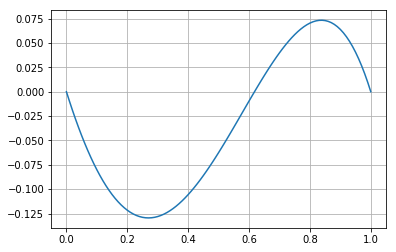

In [24]:
def vertical(p):
    return p ** 4 + 4 * p ** 3 * (1 - p) + 2 * p ** 2 * (1 - p) ** 2

ps = np.arange(0, 1.01, 0.01)

p = 0.5
for i in range(2, 25):
    if vertical(p) - p > 0:
        p -= 2 ** (-i)
    else:
        p += 2 ** (-i)a
    print(p)

plt.plot(ps, vertical(ps) - ps)
plt.grid()
plt.show()